In [12]:
%load_ext autoreload
%autoreload 2

import os
import subprocess
import sys
import warnings

warnings.simplefilter("ignore", FutureWarning)

%aimport cnv_inference_config
project_config = cnv_inference_config
os.chdir(project_config.MB_ROOT)

from collections import Counter, defaultdict, OrderedDict
import multiprocessing as mp
import pickle

from joblib import Parallel, delayed
import numpy as np
import pandas as pd
from tqdm import tqdm, tqdm_notebook

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from typing import Dict, List, Iterable, Callable
import scipy.stats as sps

from classification.models.mle_classifier import AseMleClassifier
import toolkit
import util
from workspace.workspace_manager import WorkspaceManager

from classification.simulations.fixed_size_sampler import FixedSizeSampler
from classification.simulations.simulation_manager import SimulationManager
import classification.simulations.reporting as simulation_report

sns.set()

workspace = {}
for data_type in ["scDNA", "scRNA"]:
    workspace.update({ 
        data_type : WorkspaceManager(
            task_name="ase_to_cnv",
            experiment_info={"data" : data_type},
            verbose=True
        )
    })
    workspace[data_type].load_workspace()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Loading data

In [13]:
clustering_tag = {
    "scDNA" : "cnv_3",
    "scRNA" : "seurat"
}
filtering_tag = "all"
data = {}
for data_type in ["scDNA", "scRNA"]:
    data[data_type] = {
        data_name :
        util.pickle_load(data_dump)
        for data_name, data_dump in tqdm_notebook(
            workspace[data_type].tmp_data.items(),
            f"{data_type}, loading datasets into RAM"
        )
    }

# Looking at the data

## Comparing gene expression profiles

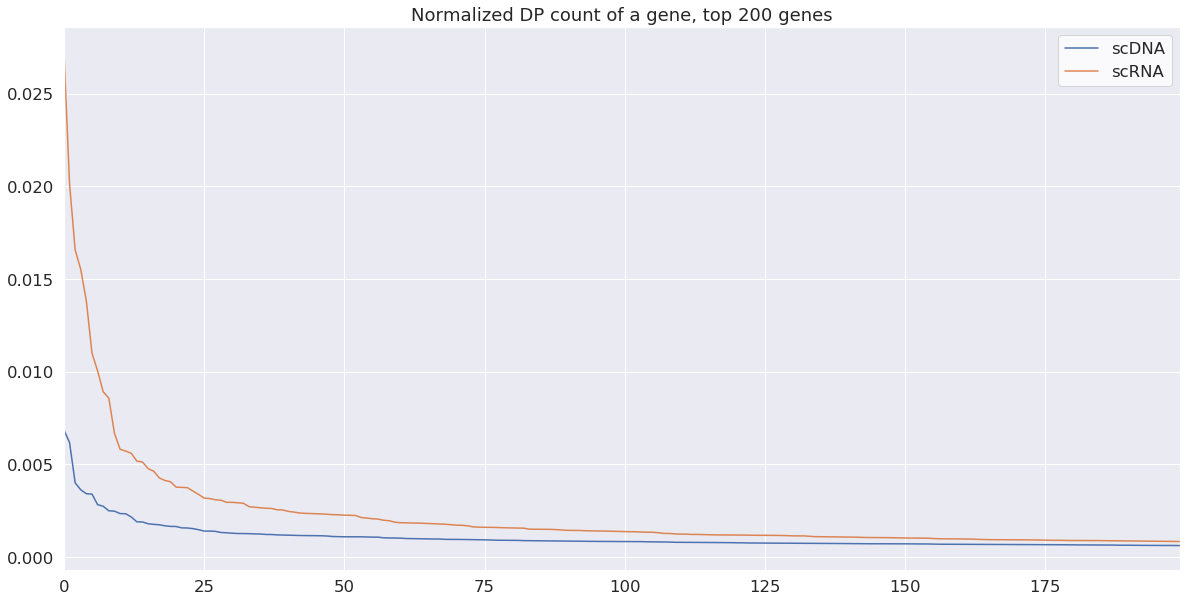

In [19]:
sns.set(font_scale=1.5)
n_ratios = 200
plt.figure(figsize=(20,10))
plt.title(f"Normalized DP count of a gene, top {n_ratios} genes")
for data_tag in ["scDNA", "scRNA"]:
    ase_template_df, gene_counts_df = prepare_input(data_tag)

    sampler = FixedSizeSampler(
        ase_template_df,
        gene_counts_df, 
        TOTAL_COUNT_DEPTH,
        CELLS_PER_PROFILE,
        verbose=False
    )
    
    sampler.count_profile\
    .sort_values(ascending=False)\
    .reset_index(drop=True)\
    .iloc[:n_ratios]\
    .plot(label=data_tag)
    
frame = plt.legend().get_frame()
frame.set_facecolor("white")

# Running simulations (FixedSizeSampler)

**Description:** https://docs.google.com/document/d/1IdldVqQPa8cE1z6tR2nAJA2OSMpodUeuncggUekFMnc/edit?usp=sharing

In [14]:
data_tag = "scRNA"
total_count_depths = 10 ** np.arange(1, 7)
CELLS_PER_PROFILE = 100

def prepare_input(data_tag):
    ase_df = data["scDNA"]["ase"]
    clustering_df = data[data_tag]["clustering"]
    gene_counts_df = data[data_tag]["gene_counts"]
    
    template_genes = data["scDNA"]["gene_counts"]["GENE_ID"]
    common_genes = (set(template_genes) & set(gene_counts_df["GENE_ID"]))
    
    ase_template_df = ase_df[
        template_genes
        .isin(common_genes)
    ]
    gene_counts_df = gene_counts_df[
        gene_counts_df
        ["GENE_ID"]
        .isin(common_genes)
    ]
    return ase_template_df, gene_counts_df
    
def simulation_process_handler(TOTAL_COUNT_DEPTH):
    ase_template_df, gene_counts_df = prepare_input(data_tag)

    sampler = FixedSizeSampler(
        ase_template_df,
        gene_counts_df, 
        TOTAL_COUNT_DEPTH,
        CELLS_PER_PROFILE,
    )
    
    classifier = AseMleClassifier(ase_template_df)
    
    simulation_manager = SimulationManager(
        classifier, 
        sampler, 
        verbose=True
    )
    y_true, y_pred = simulation_manager.run_simulations()
    return y_true, y_pred

In [17]:
%%time

pool = mp.Pool(total_count_depths.size)
simulation_results = pool.map(simulation_process_handler, 
                              total_count_depths)
pool.close()
pool.join()

Done with sampling
Done with sampling
Done with predicting
Done with predicting
Done with sampling
Done with predicting
Done with sampling
Done with sampling
Done with sampling
Done with predicting
Done with predicting
Done with predicting
CPU times: user 275 ms, sys: 718 ms, total: 993 ms
Wall time: 48.8 s


# Analyzing the label assignment

## Confusion matrices

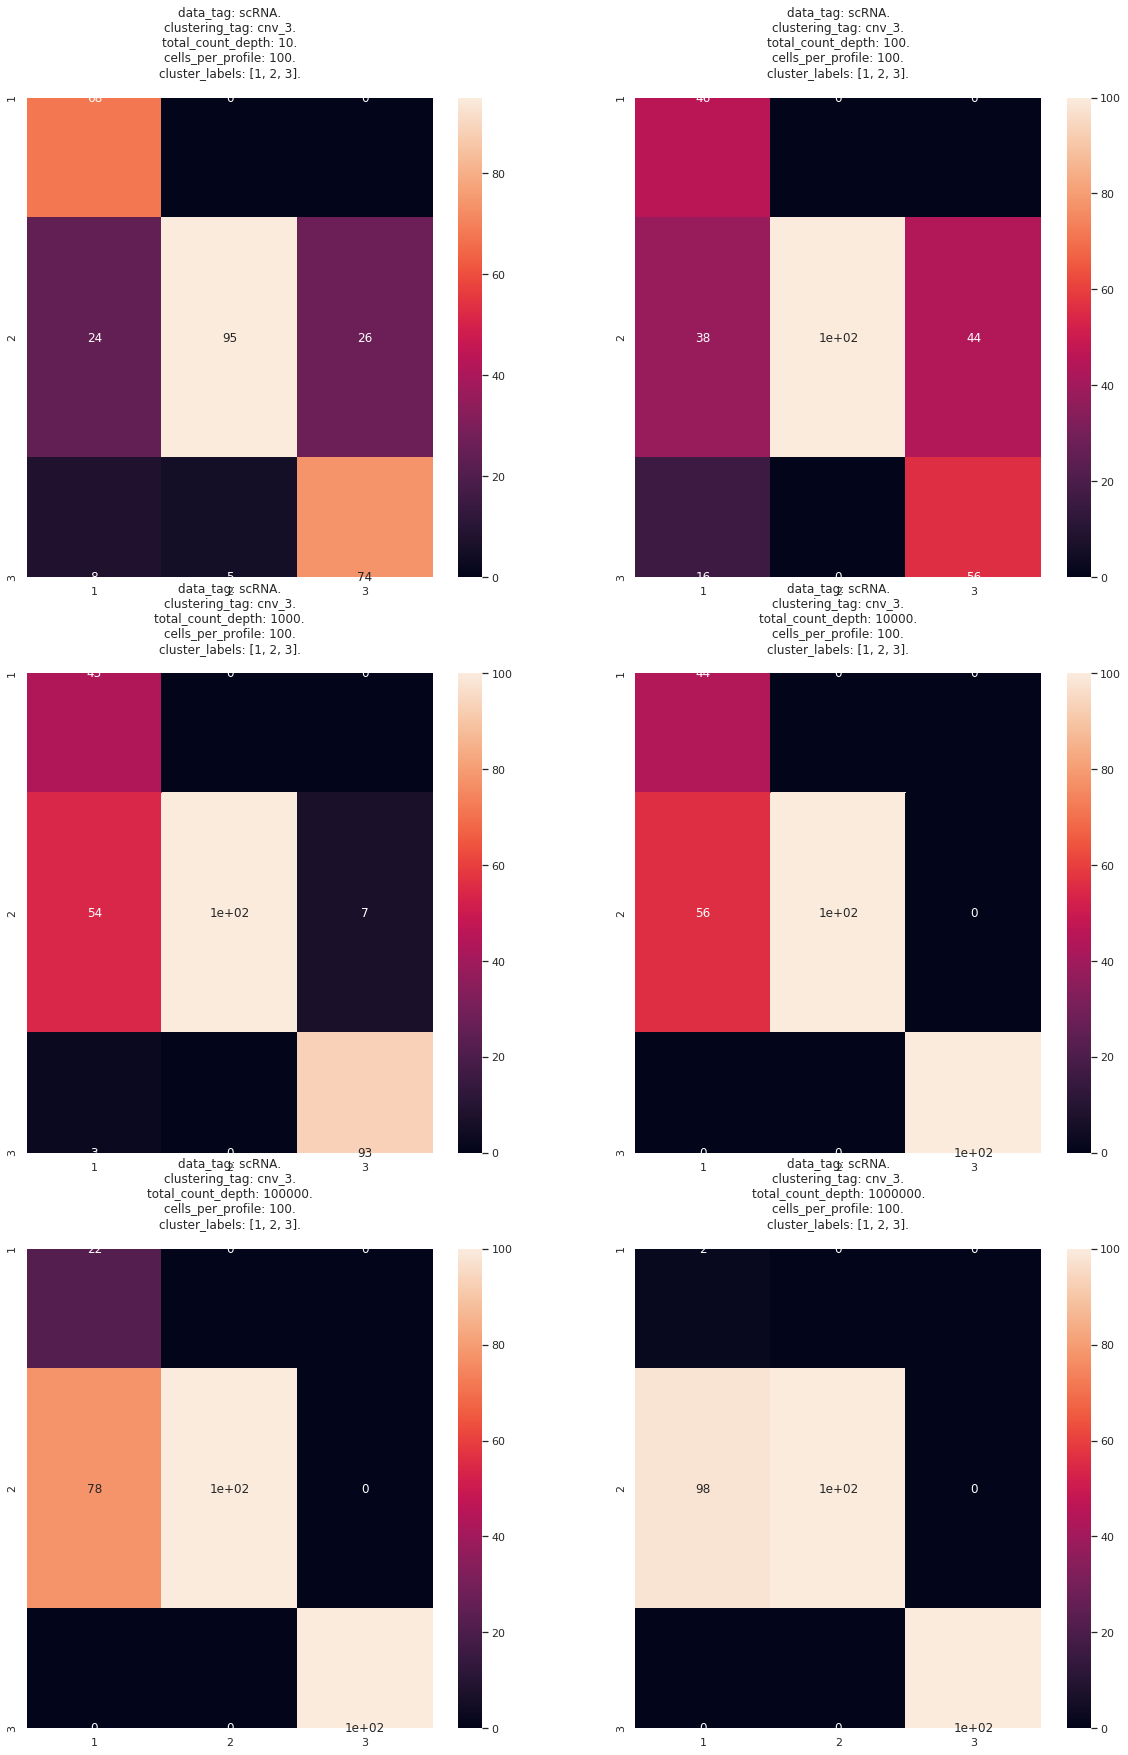

In [18]:
fig, axes = plt.subplots(3, 2, figsize=(20,30))
for i, TOTAL_COUNT_DEPTH in enumerate(total_count_depths):
    y_true, y_pred = simulation_results[i]
    ax = axes[i // 2, i % 2]
    context_info = {
        "data_tag" : data_tag,
        "clustering_tag" : clustering_tag["scDNA"],
        "total_count_depth" : TOTAL_COUNT_DEPTH,
        "cells_per_profile" : CELLS_PER_PROFILE,
        "cluster_labels" : sorted(data["scDNA"]["clustering"]["LABEL"].unique())
    }
    simulation_report.plot_confmat(
        y_true, 
        y_pred, 
        ax, 
        context_info
    )